In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
import string
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures


In [2]:
# nltk.download([
#     "names",
#     "stopwords",
#     "averaged_perceptron_tagger",
#     "vader_lexicon",
#     "punkt_tab",
#     "wordnet",
#     "vader_lexicon",
# ])


In [26]:
reviews = pd.read_csv("/Users/kenogihara/Desktop/ALL_PROJECTS/sentiment_analysis/tripadvisor_hotel_reviews.csv")
reviews.head()

markdown = reviews.head(2).to_markdown(index = True)
markdown

'|    | Review                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [4]:
"""
Main research question:
What specific attributes make a good hotel and a bad one? In what ways
could hotel improve their services based on customer reviews?
"""

'\nMain research question:\nWhat specific attributes make a good hotel and a bad one? In what ways\ncould hotel improve their services based on customer reviews?\n'

In [21]:
#Univariate analysis that shows the distribution of ratings

data = reviews.groupby("Rating").count().reset_index()

fig = px.bar(data, x = "Rating", y = "Review")
fig.update_layout(yaxis_title = "Number of Ratings")

fig.show()

fig.write_html("/Users/kenogihara/Desktop/ALL_PROJECTS/sentiment_analysis/assets/plot1.html", include_plotlyjs = "cdn")

In [6]:
#Separating all reviews from texts to words
reviews["tokenized"] = reviews["Review"].apply(nltk.word_tokenize)

In [7]:
#Filtering every review by removing stopwords with lambda function
stopwords = nltk.corpus.stopwords.words("english")
stopwords.extend(["n't", "did"])
punctuation = set(string.punctuation)

reviews["tokenized"] = reviews["tokenized"].apply(
    lambda review: [word for word in review if word not in stopwords
                    and word not in punctuation])
# reviews


In [8]:
all_words = " ".join([word for token_list in reviews["tokenized"] for word in token_list])
tokenized_all_words = nltk.tokenize.word_tokenize(all_words)


In [9]:
frequency_dist = FreqDist(tokenized_all_words)

reviews["fdist"] = reviews["tokenized"].apply(lambda text: " ".join([word for word in text if frequency_dist[word] >= 1]))
# reviews

In [10]:
wordnet_lem = WordNetLemmatizer()

reviews["lemmatized"] = reviews["fdist"].apply(wordnet_lem.lemmatize)

#Check if the columns are equal
reviews["is_equal"] = (reviews["fdist"] == reviews["lemmatized"])

#If it's equal to the number of data points, then there are no words to lemmatize
reviews.is_equal.value_counts()

True    20491
Name: is_equal, dtype: int64

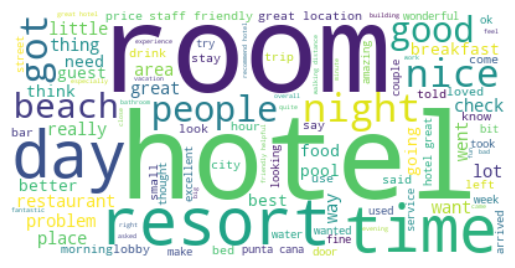

In [11]:
#Word cloud
all_words_lem = " ".join([word for word in reviews["lemmatized"]])

%matplotlib inline
default_font_path = "/Users/kenogihara/Desktop/ALL_PROJECTS/sentiment_analysis/dejavu-sans/DejaVuSans.ttf"

wordcloud = WordCloud(max_font_size = 100,
                      max_words = 100,
                      random_state = 2,
                      background_color = "white").generate(all_words_lem)

plt.figure()
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.show()



In [12]:
words = nltk.word_tokenize(all_words_lem)
fd = FreqDist(words)

#Plotting most common words
top_10 = fd.most_common(10)
fdist = pd.DataFrame(pd.Series(dict(top_10)), columns = ["Count"])

sns.set_theme(style = "ticks")

fig = px.bar(fdist)
fig.update_layout(barmode = "stack", xaxis_title = "Word", yaxis_title = "Count")
fig.show()




In [13]:
#Sentiment Analyzer

analyzer = SentimentIntensityAnalyzer()

reviews["polarity"] = reviews["lemmatized"].apply(lambda x: analyzer.polarity_scores(x))

#Splitting up polarity column into their own columns
reviews = pd.concat([reviews, reviews["polarity"].apply(pd.Series)], axis = 1)
reviews.head(3)



,Review,Rating,tokenized,fdist,lemmatized,is_equal,polarity,neg,neu,pos,compound
0,nice hotel expensive parking got good deal sta...,4,"[nice, hotel, expensive, parking, got, good, d...",nice hotel expensive parking got good deal sta...,nice hotel expensive parking got good deal sta...,True,"{'neg': 0.056, 'neu': 0.621, 'pos': 0.324, 'co...",0.056,0.621,0.324,0.9808
1,ok nothing special charge diamond member hilto...,2,"[ok, nothing, special, charge, diamond, member...",ok nothing special charge diamond member hilto...,ok nothing special charge diamond member hilto...,True,"{'neg': 0.053, 'neu': 0.701, 'pos': 0.246, 'co...",0.053,0.701,0.246,0.9946
2,nice rooms not 4* experience hotel monaco seat...,3,"[nice, rooms, 4, experience, hotel, monaco, se...",nice rooms 4 experience hotel monaco seattle g...,nice rooms 4 experience hotel monaco seattle g...,True,"{'neg': 0.059, 'neu': 0.697, 'pos': 0.244, 'co...",0.059,0.697,0.244,0.9923


In [14]:
reviews["sentiment"] = reviews["compound"].apply(lambda x: "positive" if x >= 0.05 else "negative" if x <= -0.05 else "neutral")

#Review with the most positive sentiment
reviews.loc[reviews["compound"].idxmax()]["Review"]

#Review with the most negative sentiment
reviews.loc[reviews["compound"].idxmin()]["Review"]


'414 hotel worst accomodation experience life, extremely upset service provided 414 hotel took 6 weeks follow visit expedia did anything.this worst hotel experience life, wife visiting new york hospital visits booked 2 nights hotel expedia order wife homely feel relaxed medical tests procedures, arrived 9.45 pm august 9 2005 elected check finding restaurant eat, called hotel advise arriving time, start complaints disgust future occupants dealing hotel__Ç_é_ dreadful behaviour.the following based notes took various times ordeal suffered not exhaustive complaints have.i note limited sample problems hotel.\x8fàÀthe bathroom revoltingly rusty radiator looked like falling apart, bed sheets stained filthy, request replacement sheets left bed ourselves.\x8fàÀthe called king size bed simply 2 single beds pushed together.\x8fàÀthe headboard affixed wall filthy did not appear dusted months.\x8fàÀthere holes wall room, large step descending room dangerous caused trip times.\x8fàÀneither bathroom 

In [15]:
#Visualize data

data = reviews.groupby("sentiment").count().reset_index().sort_values(by = "Review", ascending = False)

fig = px.pie(data, names = "sentiment", values = "Review")
fig.show()



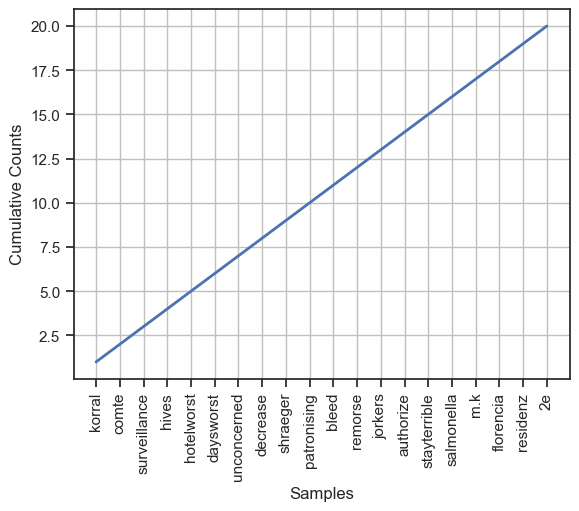

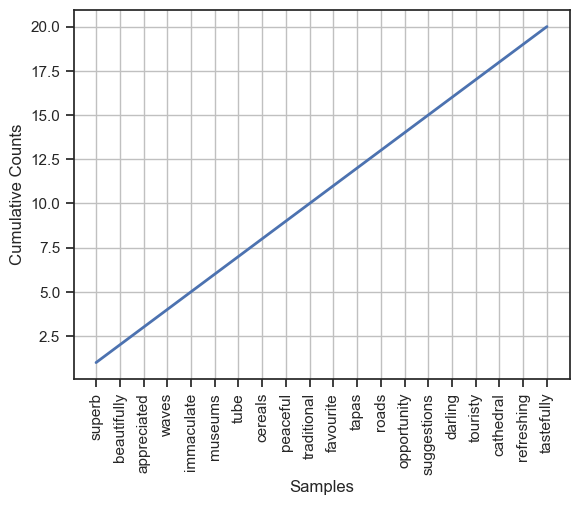

In [16]:
#Putting negative and positive reviews in their corresponding lists
neg_reviews_text = "".join(reviews[reviews["sentiment"] == "negative"]["lemmatized"].to_list())
pos_reviews_text = "".join(reviews[reviews["sentiment"] == "positive"]["lemmatized"].to_list())

#Finding common themes among each sentiment
neg_words = nltk.word_tokenize(neg_reviews_text)
pos_words = nltk.word_tokenize(pos_reviews_text)

fd_neg = FreqDist(neg_words)
fd_pos = FreqDist(pos_words)


"""
Seems like there are many words that are showed by both negative and 
positive sentiment reviews. We can do an analysis on words that are 
particular to a certain sentiment.
"""

very_neg = [word for word, count in fd_neg.most_common() if word not in fd_pos]
very_pos = [word for word, count in fd_pos.most_common() if word not in fd_neg]

fd_very_neg = FreqDist(very_neg)
fd_very_neg.plot(20, cumulative = True)
plt.show()

fd_very_pos = FreqDist(very_pos)
fd_very_pos.plot(20, cumulative = True)
plt.show()



[('punta', 'cana'), ('walking', 'distance'), ('staff', 'friendly'), ('san', 'juan'), ('friendly', 'helpful'), ('highly', 'recommend'), ('minute', 'walk'), ('new', 'york'), ('air', 'conditioning'), ('make', 'sure')]
[('punta', 'cana'), ('credit', 'card'), ('air', 'conditioning'), ('customer', 'service'), ('san', 'juan'), ('travel', 'agent'), ('5', 'star'), ('needless', 'say'), ('new', 'orleans'), ('puerto', 'rico')]
Displaying 25 of 358 matches:
                              warwick bad good reviews warwick shocks staff qui
ing room room away highway road noise bad wife didnot sleep wink night morning 
 got rooms i-5 freeway building noise bad large container trucks rumbling night
 called visa disputed charge.ok hotel bad managementchecked tripadvisor place t
ncing manager budge giving compensate bad experience offer smaller room stay st
om possiblesadly disappointing spotty bad service mixed overhyped atmosphere ro
osphere rooms quaint air conditioning bad sleep high hard acheive consi

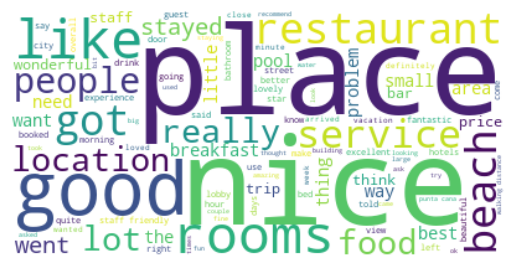

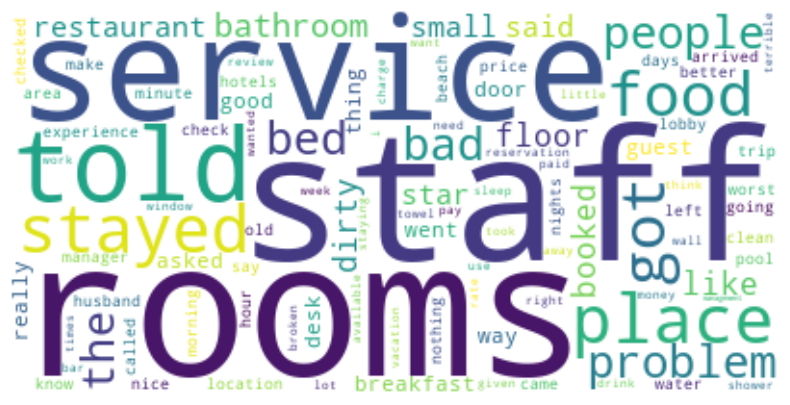

'\nAfter we eliminate common words like "hotel", "room", or "day", we have\na better understanding of what words or experiences are associated with\npositive reviews and negative reviews.\n\nFor example, applying concordance on "good" shows that people like the\nlocation, place, beach, the rooms, service, restaurants, and people.\nApplying concordance on "bad" on the other hand shows that people\nhave a negativ sentiment towards rooms, service, staff, the \ncleaniness, and bathrooms. Staff and service are words that are often\nassociated with the word "bad". This gives insight into what hotels\nshould be working on to satisfy their customers.\n\n'

In [17]:
#This doesn't really tell us much about how hotels can improve their services

# Let's use context analysis
# bigrams give us pairs of words that are associated with each other

pos_bigram_finder = BigramCollocationFinder.from_words(pos_words)
pos_bigrams = pos_bigram_finder.nbest(BigramAssocMeasures.likelihood_ratio, 10)

neg_bigram_finder = BigramCollocationFinder.from_words(neg_words)
neg_bigrams = neg_bigram_finder.nbest(BigramAssocMeasures.likelihood_ratio, 10)

print(pos_bigrams)
print(neg_bigrams)

#Concordance allows us to use keywords in context
neg_text_blob = nltk.Text(neg_words)
neg_text_blob.concordance("bad")
neg_text_with_bad = " ".join(neg_words)

pos_text_blob = nltk.Text(pos_words)
pos_text_blob.concordance("good")
pos_text_with_good = " ".join(pos_words)


#Word cloud
%matplotlib inline
default_font_path = "/Users/kenogihara/Desktop/ALL_PROJECTS/sentiment_analysis/dejavu-sans/DejaVuSans.ttf"

custom = ["room", "hotel", "day", "resort", "time", "night", "stay", "great"]

wordcloud = WordCloud(max_font_size = 100,
                      max_words = 100,
                      random_state = 2,
                      background_color = "white",
                     stopwords = custom).generate(pos_text_with_good)

plt.figure()
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.show()


#Word cloud
%matplotlib inline
default_font_path = "/Users/kenogihara/Desktop/ALL_PROJECTS/sentiment_analysis/dejavu-sans/DejaVuSans.ttf"

wordcloud = WordCloud(max_font_size = 100,
                      max_words = 100,
                      random_state = 2,
                      background_color = "white",
                     stopwords = custom).generate(neg_text_with_bad)

plt.figure(figsize = (10, 5))
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

"""
After we eliminate common words like "hotel", "room", or "day", we have
a better understanding of what words or experiences are associated with
positive reviews and negative reviews.

For example, applying concordance on "good" shows that people like the
location, place, beach, the rooms, service, restaurants, and people.
Applying concordance on "bad" on the other hand shows that people
have a negativ sentiment towards rooms, service, staff, the 
cleaniness, and bathrooms. Staff and service are words that are often
associated with the word "bad". This gives insight into what hotels
should be working on to satisfy their customers.

"""

In [18]:
fig = px.histogram(reviews, x = "compound", histnorm = "probability",
                  title = "Histogram of Compound Scores",
                    nbins = 100
                  )

fig.show()

In [19]:
fig = px.histogram(reviews, x = "compound", color = "sentiment",
                  histnorm = "probability",
                  title = "Histogram of Compound Scores Based on Sentiment")

fig.show()